In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

users_current = pd.read_csv('./user_table.csv')
users_last = pd.read_csv('./last_year_user_data.csv')

users_current.head()
users_last.head()
#发现，今年和去年的user_table字段不一样，补齐当前user_table的字段

print("今年付费人数: {}".format(users_current.user_id.count()))
print("去年付费人数: {}".format(users_last.user_id.count()))

今年付费人数: 90400
去年付费人数: 59415


In [23]:
#读取今天的其他文件，合并到user_table表里
page_list = users_last.columns.tolist()[-5:]
page_list[-1] = 'payment_confirmation'
page_list

for item in page_list:
    dataset = pd.read_csv('./{}_table.csv'.format(item))
    dataset.rename(columns={'page': item}, inplace=True)
    column = dataset.columns.tolist()[-1]

    users_current =pd.merge(users_current, dataset, how='left', on='user_id')
    users_current[item].fillna('null', inplace=True) #因为是左连接，没有浏览页面的用户会是空值，填充0

#将home_page等列的字符数据替换成数值型数据
#users_current.head()
for item in page_list[-5:-1]:
    users_current[item]= users_current[item].map({item: 1, 'null': 0})

users_current['payment_confirmation'] = users_current['payment_confirmation'].map({'payment_confirmation_page': 1, 'null':0})
users_current.rename(columns={'payment_confirmation': 'confirmation_page'}, inplace=True)

users_current.head()

,user_id,new_user,age,sex,country,device,operative_system,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,mobile,android,Direct,3,1,1,1,0,0
1,730619,0,27,Male,UK,mobile,iOS,Direct,5,1,0,0,0,0
2,261033,0,24,Female,US,mobile,android,Seo,4,1,1,0,0,0
3,533685,0,21,Male,UK,desktop,windows,Direct,5,1,1,1,1,0
4,699480,0,17,Male,UK,mobile,iOS,Direct,6,1,1,0,0,0


In [24]:
#去年数据的探索

users_last.describe()
#去年数据，年龄最大的为123岁，可以看出这里有异常数据
users_last.boxplot(column=['age'])
#把100岁以上的数据是从哪壶
users_last = users_last[users_last['age']<100]
#users_last.info()
users_last.isnull().sum() #无缺失值
users_last.duplicated().sum() #无重复值


0

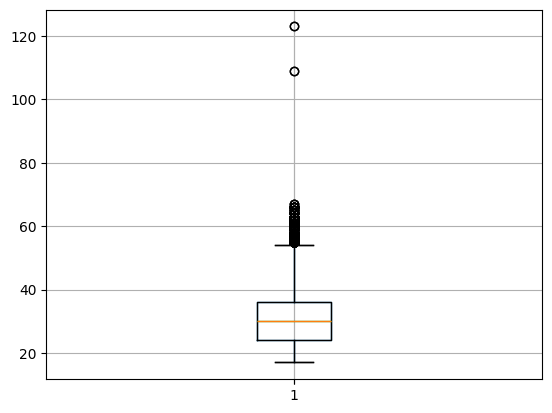

user_id                  0
new_user                 0
age                      0
sex                    773
country                 61
device                 133
operative_system       217
source                 123
total_pages_visited      0
home_page                0
listing_page             0
product_page             0
payment_page             0
confirmation_page        0
dtype: int64

In [25]:
#今年数据的探索
users_current.describe() #年龄同样有异常
plt.boxplot(users_current['age'])
plt.show()
#把100岁以上的数据剔除
users_current = users_current[users_current['age'] <100]
users_current.head()

users_current.isnull().sum()
#可以看到sex，country， device，operative_system， source字段都有缺失值



In [26]:
users_current.country.value_counts()
#country属性中us的数量最多，我们用‘us’填充
users_current['country'].fillna('US', inplace=True)

#source
users_current.groupby(['new_user', 'source']).user_id.count()
#我们可以看到，新用户主要是来着seo，老用户来自于Direct

users_current.loc[users_current['new_user']==0].source.isnull().sum() #老用户有87个缺失值
users_current.loc[users_current['new_user']==1].source.isnull().sum() #新用户有36个缺失值

#这里我们用对应的众数来填充
users_current.loc[(users_current['new_user']==1) & (users_current['source'].isnull()), 'source'] ='Seo'
users_current.loc[(users_current['new_user']==0) & (users_current['source'].isnull()), 'source'] ='Direct'


users_current.isnull().sum()


user_id                  0
new_user                 0
age                      0
sex                    773
country                  0
device                 133
operative_system       217
source                   0
total_pages_visited      0
home_page                0
listing_page             0
product_page             0
payment_page             0
confirmation_page        0
dtype: int64

In [27]:
users_current.groupby(['device', 'operative_system']).user_id.count()
#desktop多是windows， mobile多是ios

device   operative_system
desktop  linux                1185
         mac                  7204
         other                  38
         windows             28677
mobile   android             21325
         iOS                 27223
         other                4400
Name: user_id, dtype: int64

In [28]:
users_current.loc[(users_current['operative_system'].isin(['linux', 'mac', 'windows'])) & (users_current['device'].isnull()), 'device'] = 'desktop'
users_current.loc[(users_current['operative_system'].isin(['iOS', 'android', 'other'])) & (users_current['device'].isnull()), 'device'] = 'mobile'

users_current.loc[(users_current['device'] =='desktop') & (users_current['operative_system']).isnull(), 'operative_system'] = 'windows'
users_current.loc[(users_current['device'] =='mobile') & (users_current['operative_system']).isnull(), 'operative_system'] = 'iOS'

#users_current.isnull().sum()
users_current[users_current['device'].isnull()]

#可以发现存在少量的缺失值没有填充,这些缺失值是因为device，和operative_system的值都为空，由于数量少可以用总体的
#众数来填充


,user_id,new_user,age,sex,country,device,operative_system,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
8502,561375,1,36,Female,China,NaN,NaN,Ads,1,1,0,0,0,0
12227,252135,0,37,Female,China,NaN,NaN,Direct,6,1,1,1,0,0
24241,602831,0,39,Female,China,NaN,NaN,Seo,4,1,1,1,1,0
33022,190794,0,39,Female,China,NaN,NaN,Seo,6,1,1,1,0,0


In [29]:
users_current.device.value_counts() #device的众数是mobile
users_current.operative_system.value_counts() #operative_system的众数是windows

users_current.loc[users_current['device'].isnull(), 'device'] = 'mobile'
users_current.device.isnull().sum()
users_current.loc[users_current['operative_system'].isnull(), 'operative_system'] = 'windows'

users_current.isnull().sum()


#sex
users_current.sex.value_counts() #用female众来填充
users_current.loc[users_current['sex'].isnull(), 'sex'] = 'Female'
users_current.isnull().sum()

#重复值,无重复值
users_current.duplicated().sum()

users_current.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90398 entries, 0 to 90399
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              90398 non-null  int64 
 1   new_user             90398 non-null  int64 
 2   age                  90398 non-null  int64 
 3   sex                  90398 non-null  object
 4   country              90398 non-null  object
 5   device               90398 non-null  object
 6   operative_system     90398 non-null  object
 7   source               90398 non-null  object
 8   total_pages_visited  90398 non-null  int64 
 9   home_page            90398 non-null  int64 
 10  listing_page         90398 non-null  int64 
 11  product_page         90398 non-null  int64 
 12  payment_page         90398 non-null  int64 
 13  confirmation_page    90398 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 10.3+ MB


In [30]:
#GMV = 付费人数*客单价
#付费人数可以通过confirmation_page=1来统计，我们对比下去年和今年的付款人数的差异
pay_users_last = users_last.loc[users_last['confirmation_page']==1].user_id.count()
pay_users_current = users_current.loc[users_current['confirmation_page']==1].user_id.count()

print('去年的付费人数是: {}'.format(pay_users_last))
print('今年的付费人数是: {}'.format(pay_users_current))

#我们可以看到，今年的付费人数1994，比去年的1432是上涨的，但是GMV下降了，那说明肯定是客单价下降了

#我们继续分析客单价下降的原因，通过拆解用户指标，将用户分为新用户和老用户，分别算下新老用户的购买情况
users_last.groupby('new_user').confirmation_page.count()


去年的付费人数是: 1432
今年的付费人数是: 1994


new_user
0    41020
1    18393
Name: confirmation_page, dtype: int64

In [31]:
users_last.groupby('new_user').confirmation_page.sum()
agg_last = pd.pivot_table(users_last, values='confirmation_page', index='new_user', aggfunc=['count', 'sum'])
agg_current = pd.pivot_table(users_current, values='confirmation_page', index='new_user', aggfunc=['count', 'sum'])
round((agg_current-agg_last)/agg_last*100, 2)

#从客户维度对付款人数下钻可以发现
#付款人数中老用户涨幅57.69%，新用户比去年下降了12.17%
#付费人数中，老客户增长多于新客户的减少，所以总体上付费人数是增加的。

#那我们研究下哪些用户减少了,有几个维度：age、sex、country、device、operative_system、source
#users_current.info()

def pivot(index, column):
    agg_last = pd.pivot_table(users_last, values='confirmation_page', index=index, columns=column, aggfunc=['count', 'sum'])
    agg_current = pd.pivot_table(users_current, values='confirmation_page', index=index, columns=column, aggfunc=['count', 'sum'])

    return round((agg_current-agg_last)/agg_last*100, 2)

#新老客户&性别
sex_rate = pivot('new_user', 'sex' )
sex_rate
#从性别维度下钻可以发现：
#新老用户的男女增长率基本都在50%以上无明显差别，付费用户中老用户的男性涨幅明显低于女性，说明更能吸引
#老客户中的女性用户来复购
#新用户中，男女付费的用户量都减少了，男性的付款人数更是达到了-32.38%

#新老客户*国家
country_rate = pivot('new_user', 'country')
country_rate
#从国家维度下钻可以发现：
#新用户付费人数减少的主要是China和UK用户，增速分别为33.33和20.78

#新客*设备*系统
device_operate_rate = pivot(['new_user', 'device'], 'operative_system')
device_operate_rate
#从设备及系统维度下钻可以发现：
#新用户付费人数减少主要是mobile移动端的数据减少，android的减少率高达-24.36	

#新客*来源
source_rate =  pivot('new_user', 'source')
source_rate
#从客户来源的角度下钻可以发现
#Direct途径的新用户付费人数下降了77.91，其他途径的新用户付费人数呈上升趋势

#新客跟年龄
#对年龄进行分箱操作，将连续数据离散化
bins = [0, 10, 20, 30, 40, 50, 60, 70]
users_current['age_cut'] = pd.cut(users_current.age, bins=bins).astype('str')
users_last['age_cut'] = pd.cut(users_last.age, bins=bins).astype('str')

age_cut_rate = pivot('new_user', 'age_cut')
age_cut_rate
#从年龄维度下钻可以发现
#用户在【25，35】年龄区间的人数是最多的，虽然今年各个年龄区间的人数都基本有50%的涨幅
#但是今年新用户中，年龄在【20，30】区间的付费人数下降了21.29，【40-50】岁的购买率下降了42.86
#而老用户中，20岁以下的付费人数涨幅是211.21%，【20-30】的付费人数涨幅是29.05%，说明吸引老用户中的年轻人复购有明显作用


#新客*年龄*性别
age_sex_rate = pivot(['new_user', 'sex'], 'age_cut')
age_sex_rate
#从年龄和性别角度下钻，
#新客户中，各个年龄段的男性付费人数都在下降，【20-30】阶段的女性付费人数下降了16.06， (40, 50]夹断的女性付费人数下降了40%


count                                               \
age_cut         (10, 20] (20, 30] (30, 40] (40, 50] (50, 60] (60, 70]   
new_user sex                                                            
0        Female    51.28    55.23    52.60    53.31    45.98    64.71   
         Male      58.92    48.83    49.13    52.30    54.87    20.00   
1        Female    47.33    55.52    53.78    46.03    47.14    14.29   
         Male      53.60    48.60    48.18    52.53    47.96   160.00   

                     sum                                               
age_cut         (10, 20] (20, 30] (30, 40] (40, 50] (50, 60] (60, 70]  
new_user sex                                                           
0        Female   223.26    39.22    68.60    900.0   -100.0      NaN  
         Male     176.67    -0.54    48.65    200.0   -100.0      NaN  
1        Female    35.14   -16.06    27.78    -40.0   -100.0      NaN  
         Male     -37.50   -35.71   -11.76    -50.0      NaN      NaN

In [32]:
#用户行为路径
#一般的用户路径是home_page -> listing_page -> product_page -> payment_page -> confirmating_page

last_rate = pd.pivot_table(
    users_last,
    index=['home_page', 'listing_page', 'product_page', 'payment_page'],
    values='confirmation_page',
    aggfunc=['count', 'sum']
)
last_rate

current_rate = pd.pivot_table(
    users_current,
    index=['home_page', 'listing_page', 'product_page', 'payment_page'],
    values='confirmation_page',
    aggfunc=['count', 'sum']
)
current_rate

#从用户行为路径下钻我们发现
#去年的数据由很多用户的消费是跳过中间路径的，直接就达到了confirmation_page
#说明减少用户的行为路径对付费用户数量的提升有一定的帮助。

#接下来，我们再对公式进一步拆解，可以得到
#GMV = 用户人数*转化率*客单价
#用户人数较去年有很大的增长，我们接下来探索下转化率

count  \
                                                 confirmation_page   
home_page listing_page product_page payment_page                     
1         0            0            0                        24007   
          1            0            0                        21191   
                       1            0                        39170   
                                    1                         6030   

                                                               sum  
                                                 confirmation_page  
home_page listing_page product_page payment_page                    
1         0            0            0                            0  
          1            0            0                            0  
                       1            0                            0  
                                    1                         1994

In [33]:
#转化率
last_trans = users_last.confirmation_page.mean()*100
current_trans = users_current.confirmation_page.mean()*100

print('去年的转化率: {}'.format(last_trans))
print('今年的转化率: {}'.format(current_trans))
print('今年比去年: {}'.format((current_trans - last_trans)))

#可见今年的转化率比去年略低

#从新老用户角度分析
last = users_last.groupby('new_user').confirmation_page.mean()
current = users_current.groupby('new_user').confirmation_page.mean()
print('新老用户的增长情况: \n', current-last)

#今年新用户的转化率比去年降低了0.87%，老用户的转化率却只提高了0.0888%
#路径转化率

去年的转化率: 2.410246915658189
今年的转化率: 2.205801013296754
今年比去年: -0.20444590236143512
新老用户的增长情况: 
 new_user
0    0.000888
1   -0.008642
Name: confirmation_page, dtype: float64


In [34]:
#路径转化率
last_count = users_last.iloc[:, -6:-1].sum()
current_count = users_current.iloc[:, -6:-1].sum()
last_count = round(last_count.shift(-1)/last_count*100, 2)
current_count = round(current_count.shift(-1)/current_count*100, 2)
idx_lst = current_count.index.tolist()

idx = []
for x, y in zip(idx_lst, idx_lst[1:]):
    idx.append("{}->{}".format(x, y))

#import plotly.plotly as py
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Funnel(name='last', y=idx, x=last_count, texttemplate="%{x}%"))
fig.add_trace(go.Funnel(name='current', y=idx, x=current_count, texttemplate="%{x}%"))
fig.update_layout(title = '用户路径转化率对比图', dragmode=False)
fig.show(config={'displayModeBar': False})


#从路径转化率我们可以发现
#home_page->listing_page,以及listing_page->product_page的路径转化率都比较高
#但product_page -> payment_page转换率仅有13.35%，这个环节有较大的提升
#今年与去年相比，前几个路径的转化率基本一致且今年略高于去年，但最终付款环节今年却比去年少了3%。

In [35]:
#数据建模
#为了便于业务人员理解，选择了解释性强的决策树模型，用以预测用户是否回消费，了解什么样的人更可能消费

dataset = pd.concat([users_last, users_current])
dataset.reset_index(drop=True, inplace=True)

#性别
dataset['sex'] = dataset['sex'].map({'Female': 1, 'Male': 0})
dataset.sex.head()

#country
dataset['country'] = dataset['country'].map({'US': 0, 'China': 1, 'UK': 2, 'Germany': 3})
dataset['country'].head()

#device
dataset['device']= dataset['device'].map({'mobile': 0, 'desktop': 1})
dataset['device'].head()

#operative_system
dataset['operative_system'] = dataset['operative_system'].map({'windows': 0, 'iOS': 1, 'android': 2, 'mac': 3, 'linux': 4, 'other':5})
dataset['operative_system'].head()

#source
dataset['source'] = dataset['source'].map({'Direct': 0, 'Seo': 1, 'Ads': 2})
dataset['source'].head()

#age_cut
dataset['age_cut'] = dataset['age_cut'].map({'(0, 10]': 0, '(10, 20]': 1, '(20, 30]': 2, '(30, 40]': 3, '(40, 50]': 4, '(50, 60]': 5, '(60, 70]': 6})
dataset['age_cut'].value_counts()
#数据转换完成，我们对数据进行建模

age_cut
2    63192
3    50983
1    17080
4    16515
5     1930
6      111
Name: count, dtype: int64

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Y = dataset['confirmation_page']
x = dataset.drop(columns=['confirmation_page', 'user_id'])

#划分实验集和测试集
xtrain, xtest, ytrain, ytest = train_test_split(x, Y, test_size=0.2)

tr = []
te = []
#进行模型训练
for i in range(10):
    clf = DecisionTreeClassifier(random_state=1, max_depth=i+1)
    res = clf.fit(xtrain, ytrain)
    score_tr = recall_score(ytrain,clf.predict(xtrain))
    score_te = cross_val_score(clf,xtest,ytest,cv=10, scoring='recall').mean()
    tr.append(score_tr)
    te.append(score_te)    


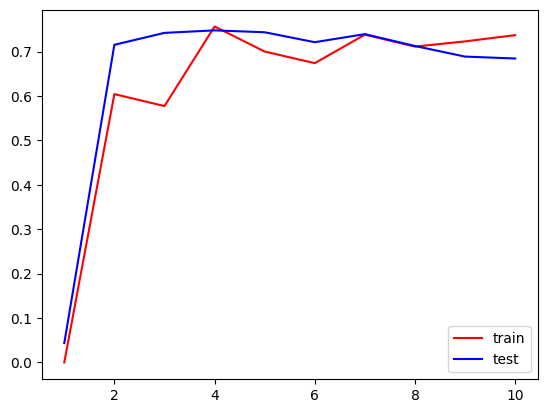

In [37]:

plt.plot(range(1,11), tr, color='red', label='train')
plt.plot(range(1,11), te, color='blue', label='test')
plt.legend()
plt.show()

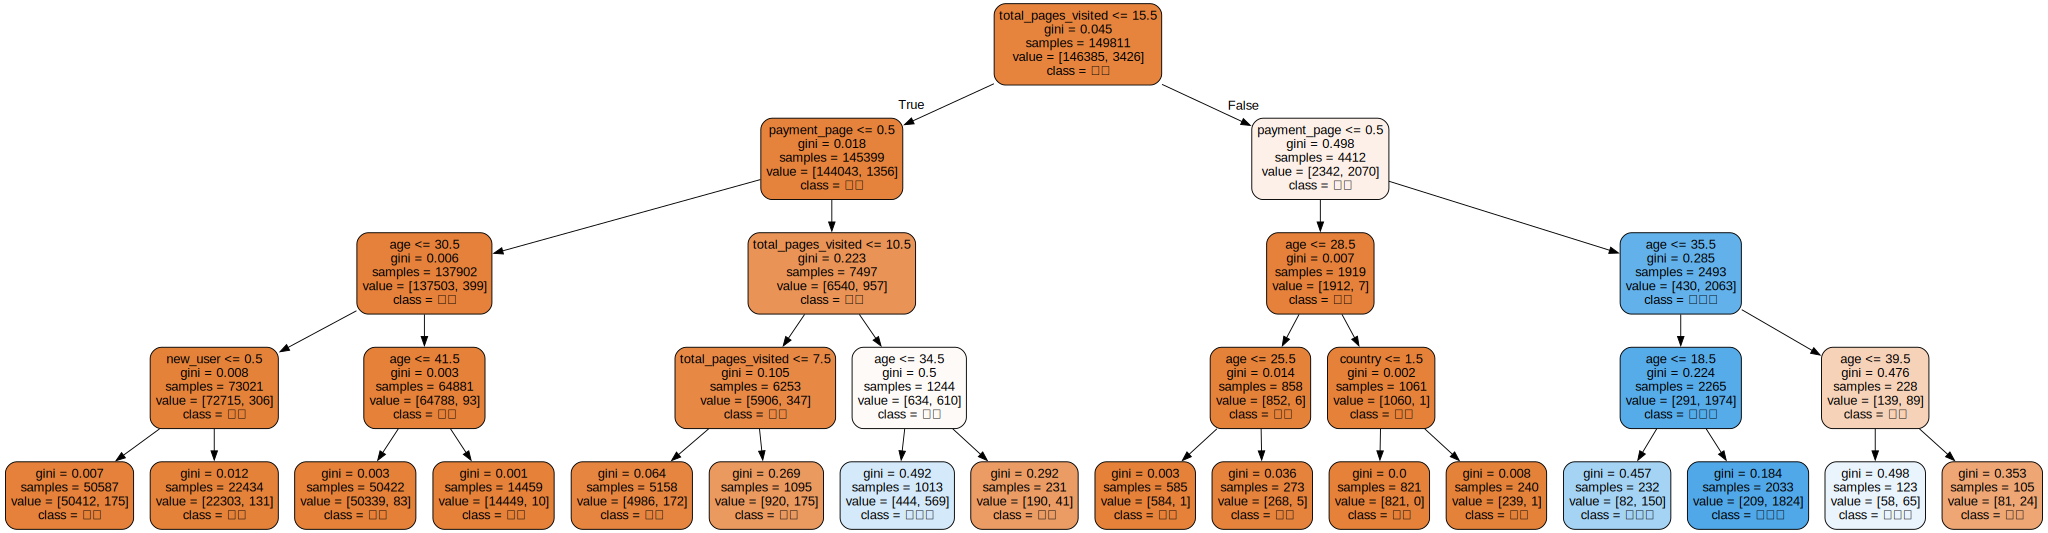

In [38]:
#根据max_depth的学习曲线可以看出，在max_depth=4时，测试集的回召率时最高的，带入做预测
clf = DecisionTreeClassifier(random_state=1, max_depth=4).fit(x, Y)

from sklearn import tree
import graphviz

data = tree.export_graphviz(
    clf,
    feature_names=x.columns.tolist(),
    class_names=['消费', '未消费'],
    filled=True, #是否给树填充颜色，
    rounded=True #圆角还是方角
)

graph = graphviz.Source(data)
graph

In [39]:
dataset.index.duplicated().sum()
type(dataset['age_cut'][0])
dataset.age_cut.isnull().sum()
dataset

import matplotlib.pyplot as plt
plt.hist(dataset['age'])

(array([22302., 30798., 33675., 28525., 19052.,  9902.,  3979.,  1170.,
          333.,    75.]),
 array([17., 22., 27., 32., 37., 42., 47., 52., 57., 62., 67.]),
 <BarContainer object of 10 artists>)